## ANSWERING BUSINESS QUESTIONS USING SQL

### INTRODUCTION

In this project, SQL skills is used to answer business questions. The Chinook database is used in this project.

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

### DATA OVERVIEW

The database is querried to get a list of all tables and views in the database:

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


Here's a schema diagram for the Chinook database:

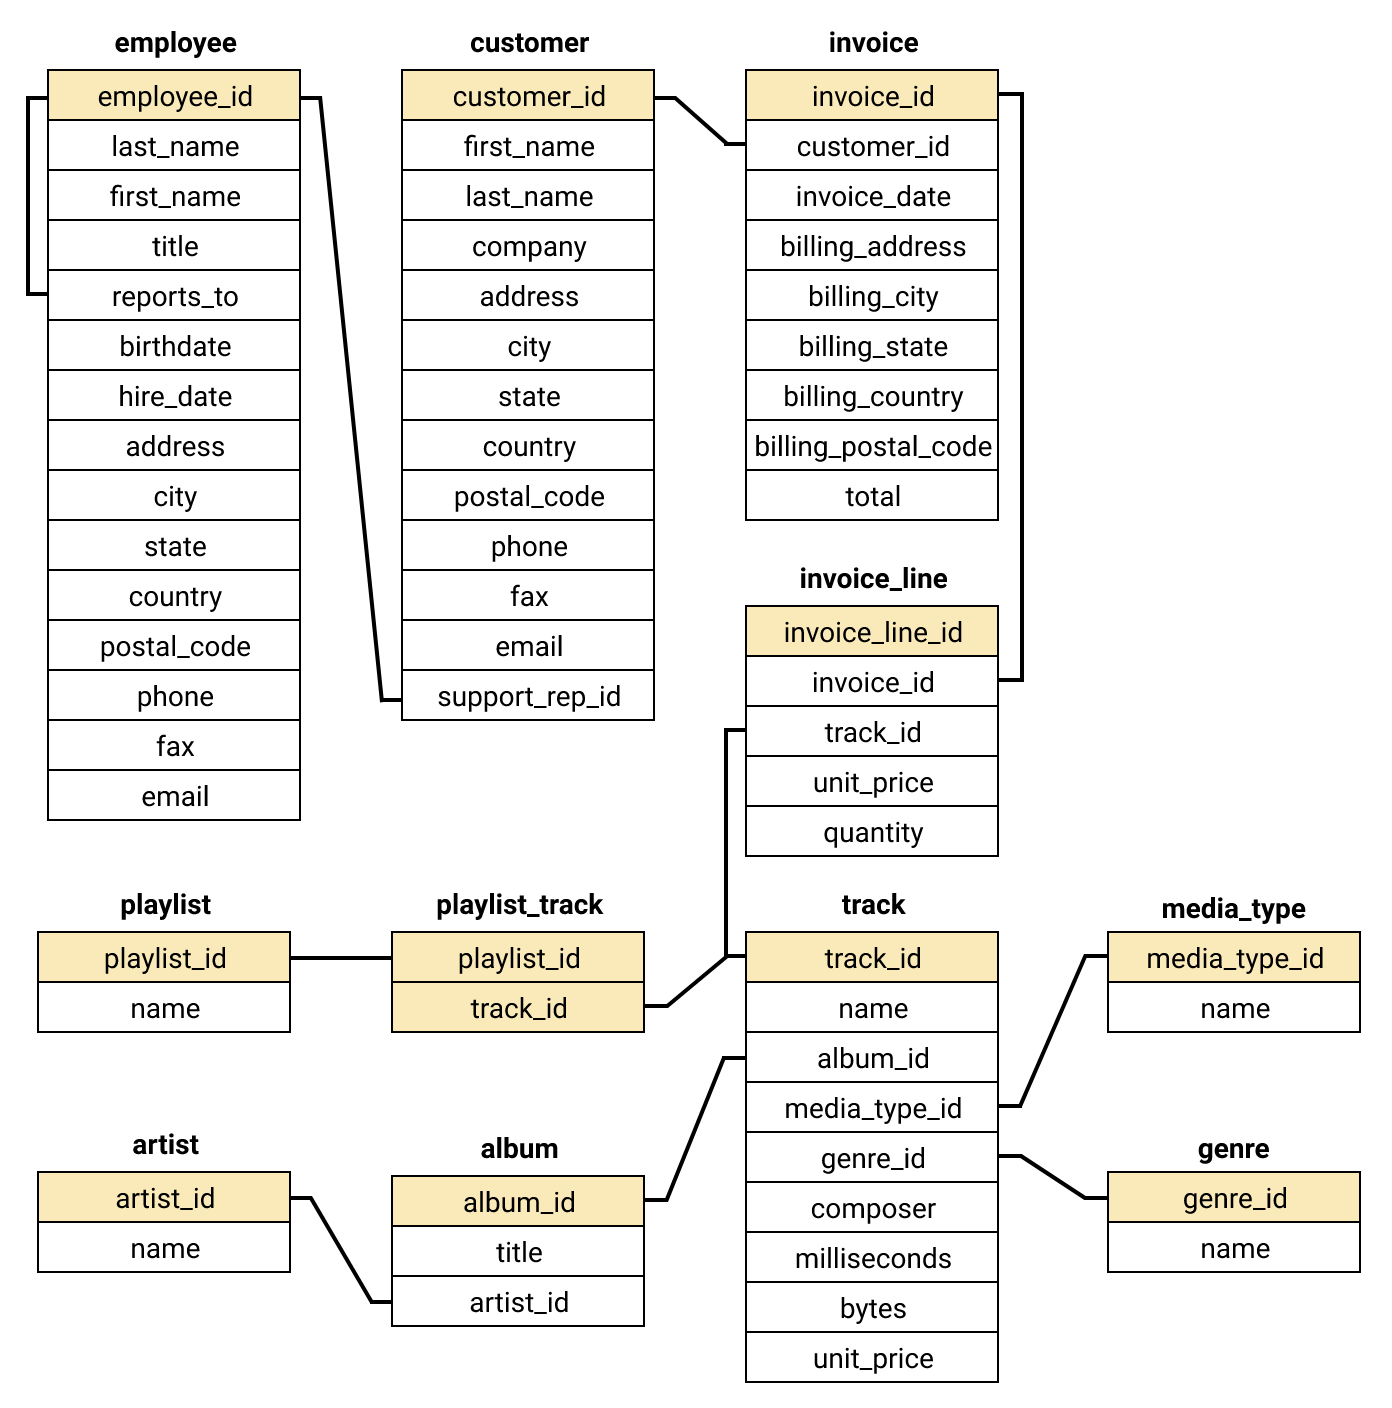

### DECIDING NEW ALBUMS TO PURCHASE

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - the artist names, and the genre of music they produce are shown in the table below:
   
|Artist Name	          |  Genre     |
|-------------------------|------------|
|Regal    	              |  Hip-Hop   |
|Red Tone	              |  Punk      |
|Meteor and the Girls     |  Pop       |
|Slim Jim Bites	          |  Blue      |

  
This project is to find out which genres sell the best in the USA because the record label specializes in artists from the USA. Hence, the need for query to find out which genres sell the most tracks in the USA. Recommendation for the three artists whose albums should purchase for the store is also made.

In [3]:
%%sql
WITH  number_us_track AS
       (
         SELECT il.* 
          FROM invoice i
            INNER JOIN customer c ON i.customer_id = c.customer_id
            INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
            WHERE c.country = "USA"
        ) 
   SELECT 
        g.name genre,
        COUNT(nut.invoice_line_id) number_sold,
        CAST(COUNT(nut.invoice_line_id) AS FLOAT)/(SELECT COUNT(*) FROM number_us_track) percentage_sold
   FROM number_us_track nut
    INNER JOIN track t ON t.track_id = nut.track_id   
    INNER JOIN genre g ON t.genre_id = g.genre_id
    GROUP BY 1
    ORDER BY 2 DESC 
    LIMIT 10;

 * sqlite:///chinook.db
Done.


genre,number_sold,percentage_sold
Rock,561,0.5337773549000951
Alternative & Punk,130,0.12369172216936251
Metal,124,0.11798287345385347
R&B/Soul,53,0.05042816365366318
Blues,36,0.03425309229305423
Alternative,35,0.03330161750713606
Pop,22,0.02093244529019981
Latin,22,0.02093244529019981
Hip Hop/Rap,20,0.019029495718363463
Jazz,14,0.013320647002854425


Considering the sales volume of tracks across different genres in the USA, we should purchase the new albums by the following artists:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

It's important to note that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

### EMPLOYEE SALES PERFORMANCE EVALUATION

###Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. The task here is to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

Evaluating the the sales representative performance based on their sales volume, Johnson Steve, Park Margaret and Peacock Jane are the peak performing sales agents. The difference in their peformance roughly corresponds with the differences in their hiring dates.

### ANALYSING SALES BY COUNTRY

The task in this section of the project is to analyze the sales data for customers from each different country.The country value from the customers table used.

The following will be calculated for each country:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Countries with only one customer are grouped as "Other" in your analysis. Ordering of "Other" is forced to come last in the analysis.

In [22]:
%%sql
WITH country_analysis AS 
         (
            SELECT 
               CASE 
                  WHEN 
                       (
                          SELECT COUNT(*)
                          FROM customer
                          WHERE country = c.country
                       ) = 1 THEN "other"
                  ELSE c.country
               END AS country,
               c.customer_id,
               il.*
             FROM customer c
             INNER JOIN invoice i ON c.customer_id = i.customer_id
             INNER JOIN invoice_line il ON i.invoice_id = il.invoice_line_id
         )
SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM 
   (
     SELECT 
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price)/COUNT(DISTINCT customer_id) customer_lifetime_value,
        SUM(unit_price)/COUNT(DISTINCT invoice_id) average_order,
        CASE 
           WHEN country = "other" THEN 1
           ELSE 0
        END AS sort
      FROM country_analysis
      GROUP BY country
      ORDER BY sort ASC, total_sales DESC
   );

 * sqlite:///chinook.db
Done.


country,customers,total_sales,average_order,customer_lifetime_value
USA,13,129.6899999999997,2.1614999999999953,9.976153846153824
Canada,8,75.23999999999998,1.6719999999999995,9.404999999999998
Brazil,5,60.390000000000036,1.4378571428571436,12.078000000000007
France,5,49.500000000000014,1.3750000000000004,9.900000000000002
Germany,4,40.589999999999996,1.2684374999999999,10.147499999999999
Czech Republic,2,29.69999999999998,1.3499999999999992,14.84999999999999
Portugal,2,28.709999999999983,1.1042307692307687,14.354999999999992
United Kingdom,3,27.719999999999985,1.3199999999999992,9.239999999999995
India,2,20.789999999999996,1.0394999999999999,10.394999999999998
other,15,145.52999999999986,2.55315789473684,9.701999999999991


From the analysis of data as shown above, there may be opportunity in the following countries:

* Czech Republic
* United Kingdom
* India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

### COMPARING ALBUMS AND INDIVIDUAL TRACKS

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In this section of the project a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics is written:
* Number of invoices
* Percentage of invoices

In [33]:
%%sql
WITH invoice_first_track AS
     (
       SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
       FROM invoice_line il
       GROUP BY 1
     )
SELECT 
   album_purchase,
   COUNT(invoice_id) number_of_invoice,
   CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percent
FROM
  (
    SELECT 
          ifs.*,
          CASE 
              WHEN (
                    SELECT t.track_id FROM track t
                    WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                        WHERE t2.track_id = ifs.first_track_id
                                        )
                    EXCEPT
                  
                    SELECT il2.track_id FROM invoice_line il2
                    WHERE il2.invoice_id = ifs.invoice_id
                   ) IS NULL
              AND 
                   (
                    SELECT il2.track_id FROM invoice_line il2
                    WHERE il2.invoice_id = ifs.invoice_id
                    
                    EXCEPT
                       
                    SELECT t.track_id FROM track t
                    WHERE t.album_id = (
                                         SELECT t2.album_id FROM track t2
                                         WHERE t2.track_id = ifs.first_track_id
                                        )
                   ) IS NULL
                   THEN "yes"
                   ELSE "no"
          END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
   

 * sqlite:///chinook.db
Done.


album_purchase,number_of_invoice,percent
no,500,0.8143322475570033
yes,114,0.18566775244299674


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

### CONCLUSION

Some of the findings are :

* From analysing the most commonly sold genres in USA , its found that Rock music tracks are most liked by the music lovers which is around 53.378 % followed by Alternative &Punk,Metal,R&B/Soul in that order.
* The chinook store should continue to buy single tracks from record companies since the percentage of full album purchased is only 18.56 % where as single track purchase is 81.43 % .